In [1]:
import pandas as pd
import numpy as np

In [2]:
trade_bra = pd.read_csv('data/trade_bra.csv', dtype = {'HS ID 4': str}).dropna(subset = ['Exports', 'Imports'])
wages_bra = pd.read_csv('data/wages_bra.csv').dropna(subset = ['Total Jobs', 'Total Yearly Wages'])

# wages_bra_raw = wages_bra_raw.sample(frac = .)

In [3]:

def filter_small_cats(df, level, cat = 'BRA ID MIR', col = 'Total Yearly Wages'):
    grouped = df.groupby(cat).sum().sort_values(by = col, ascending = False).dropna()
    cumsum = grouped.div(grouped.sum()).cumsum()
    label_sel = cumsum.loc[cumsum[col] < level].index.values
    df_ = df.loc[df[cat].isin(label_sel)]
    return df_

df1 = filter_small_cats(wages_bra, .995, 'BRA ID MIR')
df2 = filter_small_cats(df1, .995, 'CNAE ID C')
df3 = filter_small_cats(df2, .995, 'CBO ID F')

# for df in [df1, df2, df3]:
#     print np.true_divide(len(df),len(wages_bra))
#     print df['Total Yearly Wages'].sum()/wages_bra['Total Yearly Wages'].sum()

wages_bra = df3

## Info of aggregations

In [4]:
CIIU = pd.read_csv('data/Classifications/ciiu_full.csv')
CBO = pd.read_csv('data/Classifications/CBO_full.csv').astype(str)
CNAE = pd.read_csv('data/Classifications/CNAE_full.csv').astype(str)
HS = pd.read_csv('data/Classifications/hs_full.csv').astype(str)

CIIU_agg_ref = CIIU[['CIIU ID CL', 'CIIU ID D', 'CIIU ID S']]

CNAE_agg_ref = CNAE[['CNAE ID C', 'CNAE ID G', 'CNAE ID D', 'CNAE ID S']]
CNAE_agg_labels = CNAE[['CNAE ID C', 'CNAE label C', 'CNAE ID G', 'CNAE label G', 'CNAE ID D', 'CNAE label D',
                      'CNAE ID S', 'CNAE label S']]

CBO_agg_ref = CBO[['CBO ID F', 'CBO ID SG', 'CBO ID SGP', 'CBO ID GG']]
CBO_agg_labels = CBO[['CBO ID F', 'CBO label F', 'CBO ID SG', 'CBO label SG',
                      'CBO ID SGP', 'CBO label SGP', 'CBO ID GG', 'CBO label GG']]

HS_agg_ref = HS[['HS ID 4', 'HS ID 2']]
HS_agg_labels = HS[['HS ID 4', 'HS label 4', 'HS ID 2', 'HS label 2']]

geo_ids = pd.concat([wages_bra['BRA ID MIR'], trade_bra['BRA ID MIR']]).unique()
GEO_bra = pd.DataFrame([[gid[:3],gid[:5],gid]  for gid in geo_ids], columns = ['BRA ID ST', 'BRA ID MER', 'BRA ID MIR'])
# GEO_bra.to_csv('data/Classifications/GEO_bra.csv', index = False)

GEO_chi = pd.read_csv('data/Classifications/GEO_chi.csv')[['reg_id', 'prov_id', 'comuna_id']]
GEO_chi = GEO_chi.rename({'reg_id':'CHI ID REG', 'prov_id':'CHI ID PRO', 'comuna_id':'CHI ID COM'},axis = 1)


In [5]:
# Aggregate across 4 years

trade_bra_4y = trade_bra.groupby([u'BRA ID MIR', u'HS ID 4']).sum().reset_index()
wages_bra_4y = wages_bra.groupby([ u'BRA ID MIR',u'CNAE ID C', u'CBO ID F']).sum().reset_index()


In [45]:
Geo_lev = 'ST'

trade_bra_4y_gl = trade_bra_4y.merge(GEO_bra).groupby(['BRA ID '+Geo_lev, 'HS ID 4']).sum().reset_index()
wages_bra_4y_gl = wages_bra_4y.merge(GEO_bra).groupby(['BRA ID '+Geo_lev, 'CNAE ID C', 'CBO ID F']).sum().reset_index()

nodes_df_list = []
df_list =[]
confs = [('GG', 'S', '2', '2'),
         ('GG', 'D', '2', '2'),
         ('SGP', 'S', '2', '2'),
         ('SGP', 'D', '2', '2')]

for conf in confs:
    (CBO_lev, CNAE_lev, HS_Exp, HS_Imp) = conf

    # Bring 3 datasets and give them node_names. Prepare for correlation

    x = wages_bra_4y_gl.merge(CBO_agg_ref).groupby(['BRA ID '+Geo_lev, 'CNAE ID C', 'CBO ID '+CBO_lev]).sum()[['Total Yearly Wages']].reset_index()#.sample(frac = 0.1)
    x = x.merge(CNAE_agg_ref).groupby(['BRA ID '+Geo_lev, 'CNAE ID '+CNAE_lev, 'CBO ID '+CBO_lev]).sum()[['Total Yearly Wages']].reset_index()

    # use label for naming nodes
    #     x_ = x.merge(CNAE[['CNAE ID '+CNAE_lev,'CNAE label '+CNAE_lev]].drop_duplicates())
    #     x_ = x_.merge(CBO[['CBO ID '+CBO_lev, 'CBO label '+CBO_lev]].drop_duplicates())
    #     x_['node_name'] = 'Wages in ' + x_[[col for col in x_.columns if 'label' in col]].apply(' of '.join, axis=1)

    # use ID for naming nodes
    x_ = x
    x_['node_name'] = 'Wages in ' + x_[[col for col in x_.columns if 'ID' in col and 'BRA' not in col]].apply(' of '.join, axis=1)
    x_ = x_.drop([col for col in x_.columns if 'label' in col], axis = 1)
        #node size
    x_ = x_.merge(x.groupby(['CNAE ID '+CNAE_lev,'CBO ID '+CBO_lev]).sum().reset_index().rename({'Total Yearly Wages': 'node_size'}, axis = 1))
    x = x_

    x = x.merge(CNAE[list(set(['CNAE ID '+CNAE_lev,'CNAE ID S']))].drop_duplicates())
    x = x.merge(CBO[list(set(['CBO ID '+CBO_lev,'CBO ID GG']))].drop_duplicates())
    x = x.rename({'CNAE ID S': 'att_A', 'CBO ID GG': 'att_B', 'Total Yearly Wages': 'value_USD'}, axis = 1)


    # Trade in HS2
    y = trade_bra_4y_gl.merge(HS[['HS ID 4', 'HS ID 2']].drop_duplicates()).groupby(['BRA ID '+Geo_lev, 'HS ID '+HS_Exp]).sum().reset_index()

    y_ = y.merge(HS[['HS ID '+HS_Exp,'HS label '+HS_Exp]].drop_duplicates())
    y_['node_name'] = 'Exports of ' + y_[[col for col in y_.columns if 'label' in col]].apply(' of '.join, axis=1)
    y_ = y_.drop([col for col in y_.columns if 'label' in col], axis = 1)
    y_ = y_.merge(y.groupby(['HS ID '+HS_Exp]).sum().reset_index().rename({'Exports': 'node_size'}, axis = 1),  on = 'HS ID '+HS_Exp)

    y = y_
    y = y.rename({'HS ID '+HS_Exp: 'att_A', 'Exports': 'value_USD'}, axis = 1)
    y['att_B'] = y['att_A'] = 'Exports'

    z = trade_bra_4y_gl.merge(GEO_bra).merge(HS[['HS ID 4', 'HS ID 2']].drop_duplicates()).groupby(['BRA ID '+Geo_lev, 'HS ID '+HS_Exp]).sum().reset_index()

    z_ = z.merge(HS[['HS ID '+HS_Exp,'HS label '+HS_Exp]].drop_duplicates())
    z_['node_name'] = 'Imports of ' + z_[[col for col in z_.columns if 'label' in col]].apply(' of '.join, axis=1)
    z_ = z_.drop([col for col in z_.columns if 'label' in col], axis = 1)
    z_ = z_.merge(z.groupby(['HS ID '+HS_Imp]).sum().reset_index().rename({'Imports': 'node_size'}, axis = 1), on = 'HS ID '+HS_Imp)

    z = z_
    z = z.rename({'HS ID '+HS_Exp: 'att_A', 'Imports': 'value_USD'}, axis = 1)
    z['att_B'] = z['att_A'] = 'Imports'


    #Save nodes info
    nodes_df_list += [pd.concat([x, y, z]).groupby('node_name').first()[['att_A', 'att_B', 'node_size']]]

    #Data for correlation
    df = pd.concat([x, y, z]).groupby(['BRA ID '+Geo_lev, 'node_name']).sum()[['value_USD']]
    # functions.drop_small_cats(concat_data, .95)
    df = df.unstack()
    df.columns = df.columns.droplevel(0)


    # correlations
    robust_th = 8
    corr_geolevel_yr = np.log10(df).corr(min_periods = robust_th)
    del corr_geolevel_yr.index.name
    del corr_geolevel_yr.columns.name
    col_name = 'corr_'+Geo_lev+'_'.join([c for c in conf])
    df_list += [pd.DataFrame(corr_geolevel_yr.stack(), columns = [col_name])]

    print 'done conf '+ str(conf)

done conf ('GG', 'S', '2', '2')
done conf ('GG', 'D', '2', '2')
done conf ('SGP', 'S', '2', '2')
done conf ('SGP', 'D', '2', '2')


/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:75: RuntimeWarning: divide by zero encountered in log10


### Resulting data == correlations!!! for network

In [7]:
def demean_df(df):
    dm1 = df - df.mean()
    dm2 = (dm1.T - dm1.T.mean()).T
    
    demeaned_df = dm2
    
    return demeaned_df

## Network plots

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

('GG', 'S', '2', '2')


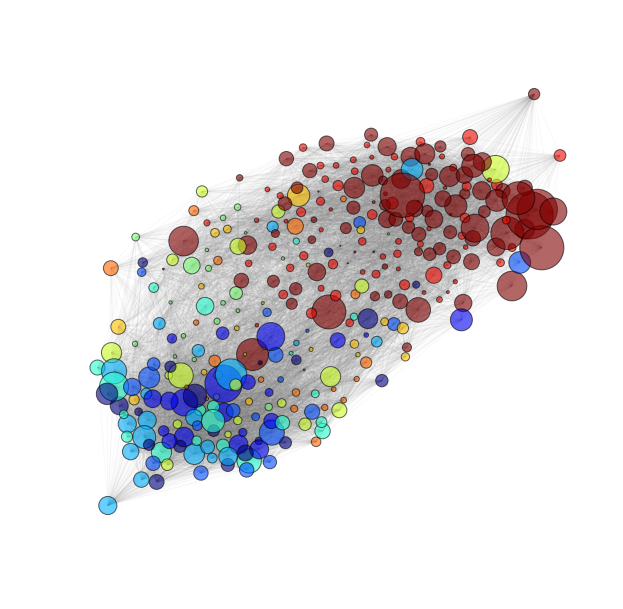

('GG', 'D', '2', '2')


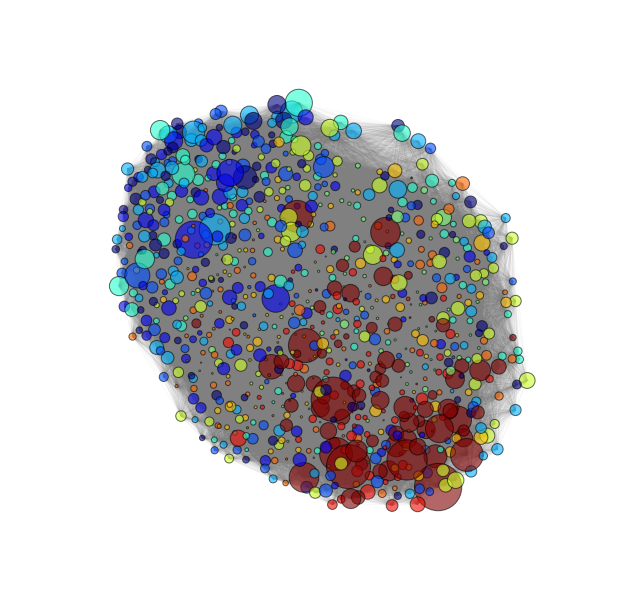

('SGP', 'S', '2', '2')


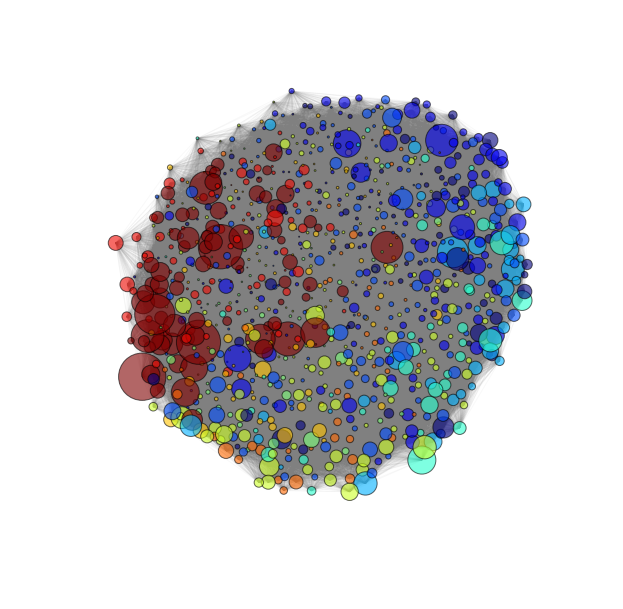

In [63]:
## DEMEANING
# i = 0
for i in range(3):
    conf = confs[i]
    print conf

    dem_corr = demean_df(df_list[i].unstack())
    dem_corr.columns = dem_corr.columns.droplevel(0)

    ## standardizing after demeaning
    std_dem_corr = dem_corr.div(dem_corr.std(), axis = 0)    

    name = 'corr_'+Geo_lev+'_'+'_'.join([c for c in conf])

    df = pd.DataFrame(std_dem_corr.stack(), columns = [name])
    network_data = df[(df[name] > df[name].quantile(4/5.)) & (df[name] < df[name].quantile(.99))]
    network_data.index.names = ['label_x', 'label_y']

    edges = network_data.reset_index().rename({name: 'weight'}, axis  =1)

    import networkx as nx

    G = nx.from_pandas_dataframe(edges, 'label_x', 'label_y', 'weight')

    # #Main component
    # grcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)
    # G0=grcc[0]

    G0 = G
    nodes = nodes_df_list[i].loc[G.nodes()]

    #Perform Graph Drawing
    plt.figure(figsize=(8, 8))
    posi = nx.spring_layout(G0, k=0.15)
    node_sizes = np.sqrt(nodes['node_size'].values)
    colors = nodes.att_B.rank(method = 'dense').values

    # 

    nx.draw(G0, posi, node_size = .001*node_sizes, alpha=.6, node_color= colors, edgelist = [])
    nx.draw_networkx_edges(G, posi, edge_color='.5', alpha=.05)
    #     plt.savefig('../DataViva/Figures/'+'_'+kw+'_'+name)
    plt.show()

In [10]:
# ### PLOT CORR VALUES
# rk = pd.DataFrame(df_list[3].reset_index().groupby('level_0').mean()[name].rank())
# rk = rk.reset_index().rename({name: 'rank'}, axis = 1)
# # 

# df_corr = pd.DataFrame(df_list[3].stack().reset_index().merge(rk))
# df_std_dem = pd.DataFrame(std_dem_corr.stack().reset_index().merge(rk))#.rename({0: 'std_dem_corr'}, axis = 1)


# dfs = [df_corr, df_std_dem]
# fig, axs = plt.subplots(1, 2, figsize = (10, 4))
# for i in range(2):
#     df = dfs[i]
#     ax = axs[i]
#     df.sample(5000, replace = True).plot(x = 0, y = 'rank', marker = '.', linestyle = 'None', alpha = .1, ax = ax)

#     if i == 0:
#         ax.set_xlim(-.5, 1)
#         ax.set_title('Pearson corr values \n for all nodes, ' +name)


#     if i ==1:
#         ax.axvline(x = df[0].quantile(2/3.), linestyle = '--', color = 'r')
#         ax.axvline(x = df[0].quantile(.99), linestyle = '--', color = 'r')
#         ax.set_xlim(-4, 4)
#         ax.set_title('Demeaned and standardized \n corr values, '+name)
# plt.show()



In [15]:
# ## DEMEANING
# conf = ('SGP', 'D', '2', '2')

# dem_corr = demean_df(df_list[3].unstack())
# dem_corr.columns = dem_corr.columns.droplevel(0)

# ## standardizing after demeaning
# std_dem_corr = dem_corr.div(dem_corr.std(), axis = 0)    

# name = 'corr_'+Geo_lev+'_'+'_'.join([c for c in tup])



In [ ]:
#Node size info (maybe should be done when the node labels are set)

df = trade_bra.merge(HS[['HS ID 2', 'HS ID 4']].drop_duplicates()).groupby('HS ID 2').sum()
nds_y = nodes_df.loc[[row for row in nodes_df.index if 'Exports' in row]].reset_index().merge(df[['Exports']].reset_index(), left_on = 'att_A', right_on = 'HS ID 2').drop('HS ID 2', axis = 1).rename({'Exports' : 'value_USD'}, axis = 1)
nds_z = nodes_df.loc[[row for row in nodes_df.index if 'Imports' in row]].reset_index().merge(df[['Imports']].reset_index(), left_on = 'att_A', right_on = 'HS ID 2').drop('HS ID 2', axis = 1).rename({'Imports' : 'value_USD'}, axis = 1)

# df = wages_bra.merge(HS['CNAE ID '+CNAE_lev, 'CBO ID '+CBO_lev].drop_duplicates()).groupby(['CNAE ID '+CNAE_lev, 'CBO ID '+CBO_lev]).sum()

nds_x = nodes_df.loc[[row for row in nodes_df.index if 'Wages' in row]].reset_index()
nds_x['value_USD'] = 1762904178 #shortcut

nodes_df = pd.concat([nds_x, nds_y, nds_z]).set_index('node_name')

# colors...
# nodes_df.merge(CNAE[['CNAE ID D', 'CNAE ID S']], left_on = 'att_A', right_on = 'CNAE ID D', how = 'left').sample(30)#.loc[G.nodes()]

In [ ]:



# nodes = data.groupby('label').sum()[['volume_USD']].dropna()





## Other

In [ ]:
# pd.concat(df_list, axis = 1).to_csv('data/Corr/corr_MER_S_GG_2_2', index = False)
# pd.concat(df_list, axis = 1).to_csv('data/Corr/corr_MER_S_GG_2_2_i')

In [ ]:
df = pd.read_csv('data/Corr/corr_MER_S_GG_2_2')

In [ ]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
pp = sns.pairplot(df.sample(10000).dropna(), diag_kind="kde", markers="+",
             plot_kws=dict(s=50, edgecolor="b", linewidth=1, alpha = .01),
             diag_kws=dict(shade=True))
[[ax.set_ylim(-.5,1) for ax in ax_list] for ax_list in pp.axes]
x = [-.5, 1]
[[ax.plot(x,x, c = '.5', linestyle = '--') for ax in ax_list] for ax_list in pp.axes]

plt.show()